Copyright (c) 2019 OERCompBiomed

# Unsupervised classification - prostate DCE-MRI

**DATA**

We are using TCIA PROSTATE-MRI data, originally in DICOM format, and corresponding Pathology Maps (cf. https://wiki.cancerimagingarchive.net/display/Public/PROSTATE-MRI). Data are downloaded to the ~/prj/Seili-2019/data/PROSTATE-MRI folder - as Dicom and PathologyMaps subfolders, respectiveley, and later converted to NIFTI format (cf. [prostate-mri-dcm2niix.ipynb](https://github.com/oercompbiomed/Seili-2019/blob/master/notebooks/prostate-mri-dcm2niix.ipynb). For illustration we will be using data from subject MIP-PROSTATE-01-0005 in the Seili-2019 data repository.

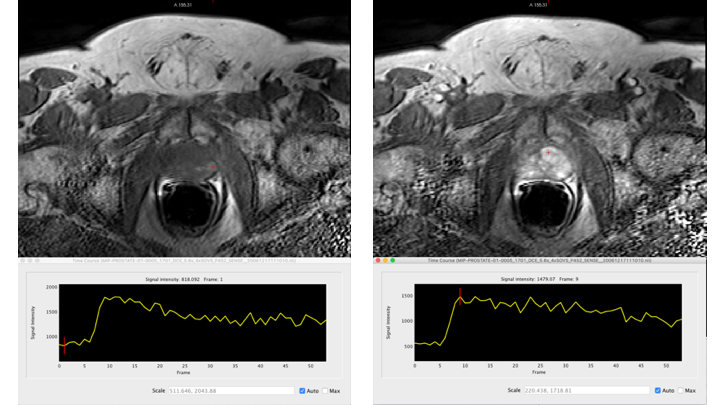

In [1]:
from IPython.display import Image
Image(filename='./assets/prostate_dce_mri_pptx.png', width=600)

**Import libraries to be used**

In [3]:
%matplotlib inline
# This to be able to display figures and graphs within the notebook browser

import os
import os.path as op
import pathlib
import glob
import shutil
import warnings
import numpy as np
import pandas as pd
import nibabel as nib
import scipy
import cv2
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.image.image import mean_img
#import joblib
from sklearn.cluster import KMeans
from nilearn.masking import apply_mask
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
import IPython

home = os.path.expanduser('~')  # To make path to local home directory

## Read the DCE-MRI data 

In [4]:
# Using nibabel to read the prostate DCE-MRI data
fn_dce_mri = '../data/PROSTATE-MRI/Nifti/MIP-PROSTATE-01-0005/MIP-PROSTATE-01-0005_1701_DCE_5.6s_4xSOVS_P4S2_SENSE__20061217111010.nii.gz'
img = nib.load(fn_dce_mri)

In [6]:
img.get_filename()

'../data/PROSTATE-MRI/Nifti/MIP-PROSTATE-01-0005/MIP-PROSTATE-01-0005_1701_DCE_5.6s_4xSOVS_P4S2_SENSE__20061217111010.nii.gz'

**Print properties of the DCE-MRI NIFTI image**

In [8]:
print('**DCE-MRI data info:**')
print('shape of image = ', img.header.get_data_shape())
print('units = ', img.header.get_xyzt_units())
print('voxel size = ', img.header.get_zooms())
print('dtype = %s' % img.header.get_data_dtype())
data = img.get_data()
print('min = %.1f' % data.min())
print('max = %.1f' % data.max())
print('number of timepoints =', img.shape[-1])
# Collaps the singular (z-)dimension
img_data = np.uint16(data.squeeze())
print('shape of 4D img_data = ',img_data.shape)
print('dtype of 4D img_data = ',img_data.dtype)
print('img affine:', img.affine)
print(img.header)

**DCE-MRI data info:**
shape of image =  (256, 256, 12, 54)
units =  ('mm', 'sec')
voxel size =  (1.0234375, 1.0234375, 6.0, 0.005)
dtype = int16
min = 0.0
max = 10819.4
number of timepoints = 54
shape of 4D img_data =  (256, 256, 12, 54)
dtype of 4D img_data =  uint16
img affine: [[-1.01999211e+00 -8.33931416e-02  5.43488003e-02  1.47407486e+02]
 [-7.87630305e-02  9.90582883e-01  1.43563271e+00 -1.14120590e+02]
 [ 2.89265011e-02 -2.43342370e-01  5.82545805e+00  3.33688202e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 54
dim             : [  4 256 256  12  54   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.0000000e+00  1

**Display selected slice and four different timeframes**

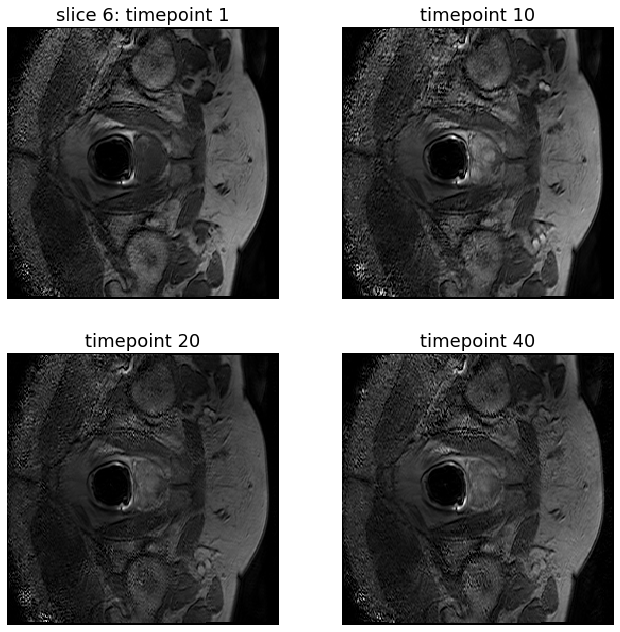

In [11]:
s = 6
t = [1, 10, 20, 40]
fig = plt.figure('Showing the DCE-MRI image', figsize = [11,11])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title('slice %d: timepoint %d' % (s, t[0]), fontsize=18)
plt.imshow(data[:, :, s, t[0]], cmap='gray', origin='lower')  
plt.subplot(2, 2, 2).set_axis_off(), plt.title('timepoint %d' % (t[1]), fontsize=18)
plt.imshow(data[:, :, s, t[1]], cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title('timepoint %d' % (t[2]), fontsize=18)
plt.imshow(data[:, :, s, t[2]], cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title('timepoint %d' % (t[3]), fontsize=18)
plt.imshow(data[:, :, s, t[3]], cmap='gray', origin='lower')
plt.show()

#fig.savefig('%s/prj/Seili-2019/results/prostate_dce_mri_slice7.png' % (home),
#            transparent=False, dpi=300, bbox_inches="tight")

> **CHECK:** 
>
> - *Coordiante systems and affine transforms in medical imaging (e.g. [nibabel](http://nipy.org/nibabel/coordinate_systems.html) / [nilearn](http://nilearn.github.io/auto_examples/04_manipulating_images/plot_affine_transformation.html))*
> - *Converting from DICOM-format (privided by the scanner) to NIFTI-format for processing (e.g. [dcm2nii](https://www.nitrc.org/plugins/mwiki/index.php/dcm2nii:MainPage) og [dcm2niix](https://github.com/rordenlab/dcm2niix))*

In [12]:
# Number of voxels in the 4D image
data.flatten().size

42467328

**Compute a 3D mean perfusion image with respect to time**

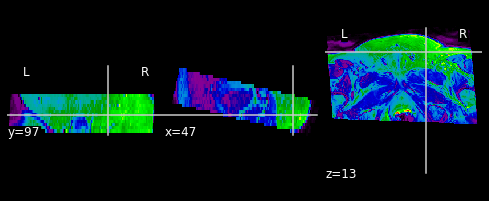

In [13]:
from nilearn.image.image import mean_img
from nilearn import plotting

# Compute the mean EPI: we do the mean along the axis 3, which is time

mean_perf = mean_img(img)

from nilearn.plotting import plot_epi, show
plot_epi(mean_perf)

display = plotting.plot_epi(mean_perf)     
display.close()

**Compute a 3D mask image derived from the 4D echo planar imaging (epi) data using [`compute_epi_mask`](https://nilearn.github.io/modules/generated/nilearn.masking.compute_epi_mask.html)**

In [22]:
from nilearn.masking import compute_epi_mask
mask_img = compute_epi_mask(img, lower_cutoff=0.05, upper_cutoff=0.2, verbose=1)

EPI mask computation


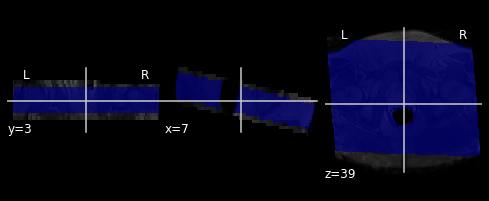

In [23]:
# Visualize it as an ROI
from nilearn.plotting import plot_roi
plot_roi(mask_img, mean_perf)

In [24]:
mask_img.shape

(256, 256, 12)

In [25]:
mask_img.get_data().shape

(256, 256, 12)

In [26]:
mask_img.get_data().max()

1

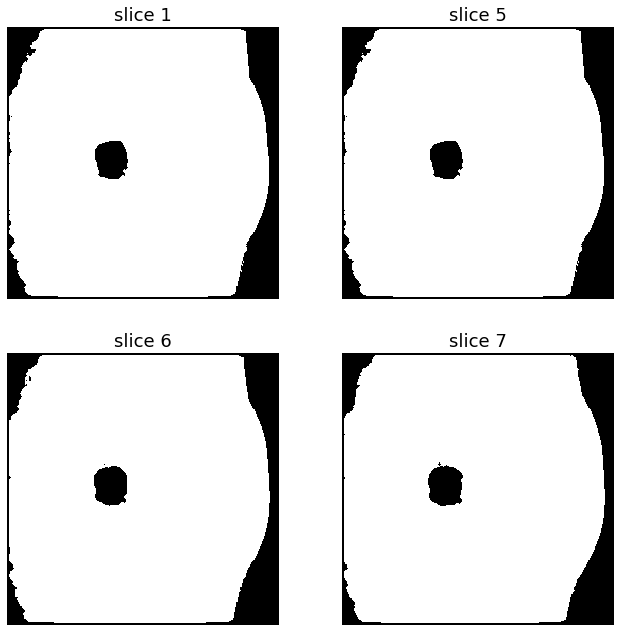

In [29]:
s = [1, 5, 6, 7]
fig = plt.figure('Showing the DCE-MRI image', figsize = [11,11])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title('slice %d' % (s[0]), fontsize=18)
plt.imshow(mask_img.get_data()[:, :, s[1]], cmap='gray', origin='lower')  
plt.subplot(2, 2, 2).set_axis_off(), plt.title('slice %d' % (s[1]), fontsize=18)
plt.imshow(mask_img.get_data()[:, :, s[1]], cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title('slice %d' % (s[2]), fontsize=18)
plt.imshow(mask_img.get_data()[:, :, s[2]], cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title('slice %d' % (s[3]), fontsize=18)
plt.imshow(mask_img.get_data()[:, :, s[3]], cmap='gray', origin='lower')
plt.show()

In [30]:
msk = mask_img.get_data()
mm = np.where(msk[:,:,:] == 1)
print('Number of voxels in the mask:', len(mm[0]))
print('i', mm[0][:5])
print('j', mm[1][:5])
print('k', mm[2][:5])

Number of voxels in the mask: 446410
i [2 2 2 2 2]
j [25 26 27 28 29]
k [9 9 9 9 9]


**[`apply_mask`](http://nilearn.github.io/modules/generated/nilearn.masking.apply_mask.html):**

In [31]:
from nilearn.masking import apply_mask

masked_data = apply_mask(img, mask_img)
print('shape of masked data:', masked_data.shape)
print('max SI in masked data:', masked_data.max())
print('99.5 percentile of SI:', np.percentile(masked_data, 99.5))

shape of masked data: (54, 446410)
max SI in masked data: 10759.803731918335
99.5 percentile of SI: 2126.4969611167908


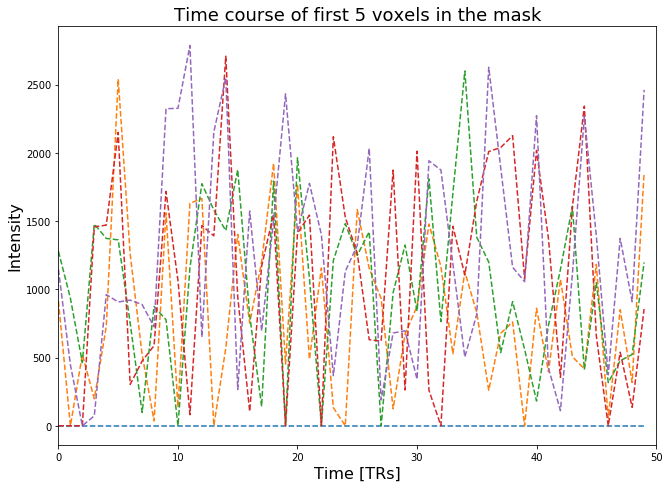

In [32]:
# masked_data shape is (timepoints, voxels). We can plot the first 50
# timepoints from nv voxels

nv = 5
# And now plot a few of these
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(masked_data[:50, :nv],'--')
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, 50)
plt.title('Time course of first %d voxels in the mask' % (nv), fontsize=18)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

### K-means clustering of time courses 

In [33]:
X = masked_data.T   # n x p data matrix, n=samples, p = feature vector dimension
K = 16  # Number of clusters
print(X.shape)
kmeans_model = KMeans(n_clusters=K, random_state=42)
print(kmeans_model)

(446410, 54)
KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=16, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)


In [34]:
kmeans_fit = kmeans_model.fit(X)

In [35]:
print('The list of cluster assignments to the enumerated voxels (n=%d):\n' % (len(mm[0])), kmeans_fit.labels_)
print('The coordinates of first kmeans.cluster_center (centroid time course):\n', kmeans_fit.cluster_centers_[0,:])

The list of cluster assignments to the enumerated voxels (n=446410):
 [ 8 10 11 ... 11  9  9]
The coordinates of first kmeans.cluster_center (centroid time course):
 [395.41223991 390.42395746 401.11545309 414.57592774 409.75875807
 412.39211768 417.21037946 398.96510111 419.04794304 448.80309974
 462.30413115 452.89476514 458.42790801 469.79452222 476.99406625
 465.05037457 460.22297883 470.43677842 486.25292053 490.08347389
 486.87189506 487.54716257 484.67354017 480.64268508 480.18007992
 472.70751    493.03170682 492.9203619  488.19299292 480.42689534
 480.55541607 489.49110697 491.79206996 487.71430406 493.18812584
 489.79158438 490.57730328 508.64893716 495.21020529 485.29842199
 490.40544588 491.41445032 493.63161919 491.00049342 490.52607369
 493.49510624 494.46310715 506.60685236 491.76868902 484.30078535
 480.11956746 491.70197142 491.20570961 489.34193555]


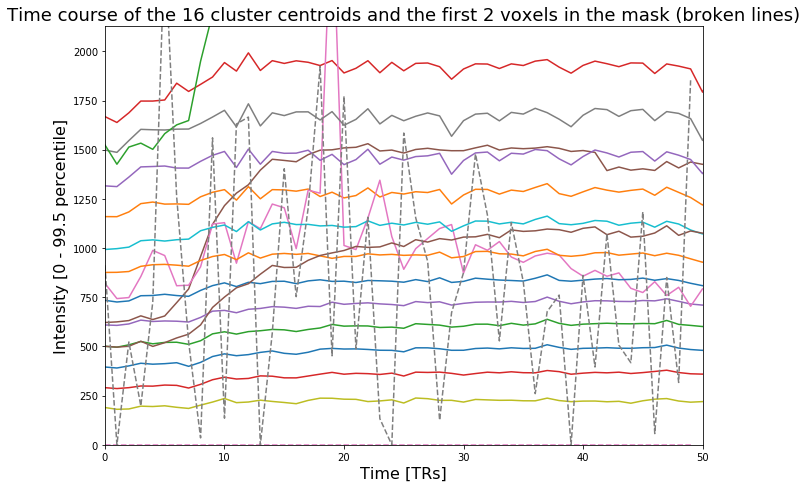

In [36]:
nv = 2

plt.figure(figsize=(10, 7))

plt.plot(kmeans_fit.cluster_centers_.T)
plt.plot(masked_data[:50, :nv], '--')
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity [0 - 99.5 percentile]', fontsize=16)
plt.xlim(0, 50)
plt.ylim(0, np.percentile(masked_data, 99.5))
plt.title('Time course of the %d cluster centroids and the first %d voxels in the mask (broken lines)' % (K, nv), fontsize=18)

plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

In [37]:
kmeans_segm = 0 * mask_img.get_data().copy()
print(kmeans_segm.shape)

for v in range(len(mm[0])):
    kmeans_segm[mm[0][v], mm[1][v], mm[2][v]] = kmeans_fit.labels_[v]

(256, 256, 12)


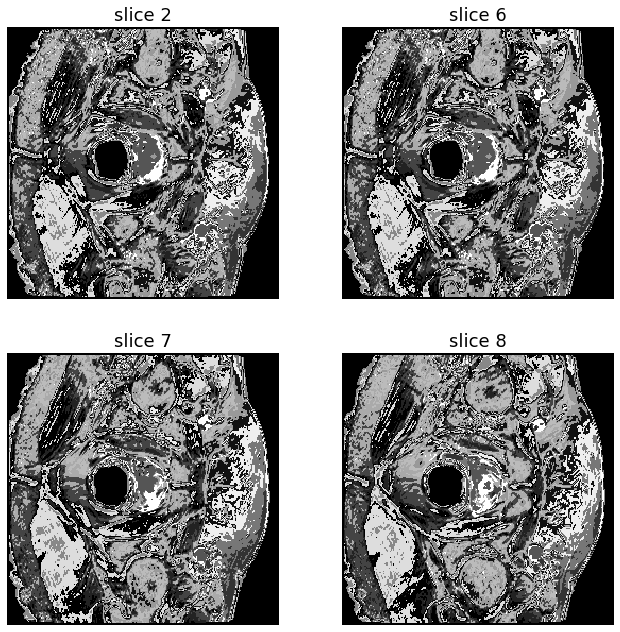

In [38]:
s = [1, 5, 6, 7]
fig = plt.figure('Showing the Kmeans clustered perfusion image', figsize = [11,11])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title('slice %d' % (s[0]+1), fontsize=18)
plt.imshow(kmeans_segm[:, :, s[1]], cmap='gray', origin='lower')  
plt.subplot(2, 2, 2).set_axis_off(), plt.title('slice %d' % (s[1]+1), fontsize=18)
plt.imshow(kmeans_segm[:, :, s[1]], cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title('slice %d' % (s[2]+1), fontsize=18)
plt.imshow(kmeans_segm[:, :, s[2]], cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title('slice %d' % (s[3]+1), fontsize=18)
plt.imshow(kmeans_segm[:, :, s[3]], cmap='gray', origin='lower')
plt.show()

**K-means "smoothed" data**

In [39]:
data_smooth = data.copy()

for v in range(len(mm[0])):
    data_smooth[mm[0][v], mm[1][v], mm[2][v]] = kmeans_fit.cluster_centers_[kmeans_fit.labels_[v],:]

data_smooth.shape

(256, 256, 12, 54)

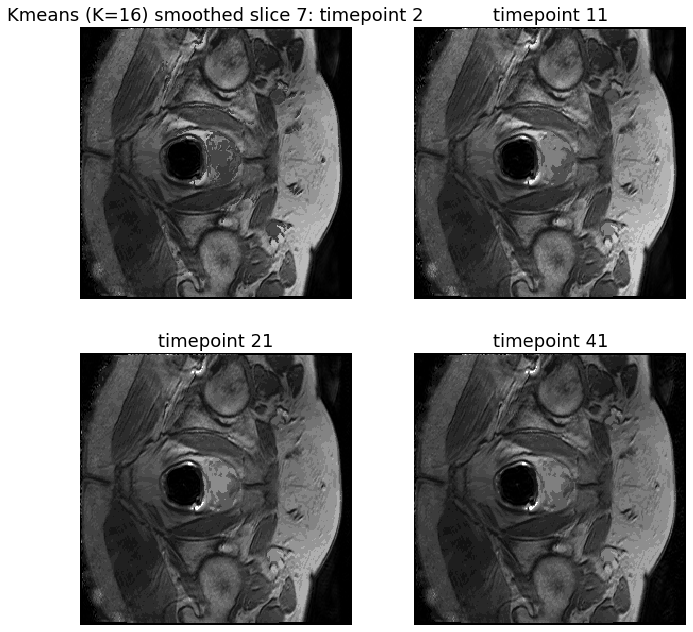

In [40]:
s = 6
t = [1, 10, 20, 40]
fig = plt.figure('Showing the Kmeans-smoothed DCE-MRI data', figsize = [11,11])
plt.tight_layout
plt.subplot(2, 2, 1).set_axis_off(), plt.title('Kmeans (K=%d) smoothed slice %d: timepoint %d' % (K, s+1, t[0]+1), fontsize=18)
plt.imshow(data_smooth[:, :, s, t[0]], cmap='gray', origin='lower')  
plt.subplot(2, 2, 2).set_axis_off(), plt.title('timepoint %d' % (t[1]+1), fontsize=18)
plt.imshow(data_smooth[:, :, s, t[1]], cmap='gray', origin='lower')
plt.subplot(2, 2, 3).set_axis_off(), plt.title('timepoint %d' % (t[2]+1), fontsize=18)
plt.imshow(data_smooth[:, :, s, t[2]], cmap='gray', origin='lower')
plt.subplot(2, 2, 4).set_axis_off(), plt.title('timepoint %d' % (t[3]+1), fontsize=18)
plt.imshow(data_smooth[:, :, s, t[3]], cmap='gray', origin='lower')
plt.show()

#### Make a new NIFTI image by passing the new smoothed data and keeping the [affine and header](https://nipy.org/nibabel/nifti_images.html) from the original image

In [41]:
img_smooth = nib.Nifti1Image(data_smooth, img.affine, img.header)

**Display the original noisy time course and the assigned (smoothed) cluster centroid time course (for first 3 time courses)**

random voxels in the mask: [128037 267336]
their voxel locations:
i: [ 76 152]
j: [176 133]
k: [2 8]


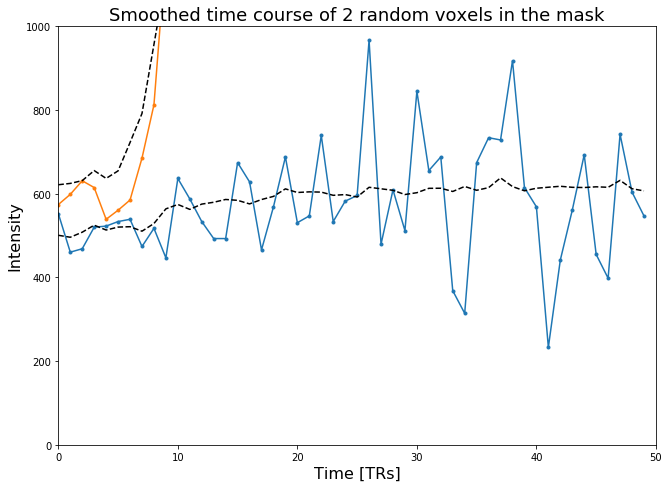

In [42]:
import random
from numpy.random import RandomState

#mask_img_smooth = compute_epi_mask(img_smooth)
masked_data_smooth = apply_mask(img_smooth, mask_img)

# masked_data shape is (timepoints, voxels). We can plot the first 50
# timepoints from two voxels

nv = 2

# seed the random number generator with a fixed value
prng = RandomState(1)
voxlist = prng.randint(0, len(mm[0]), size=nv)
# voxlist = random.sample(range(len(mm[0])), nv)

print('random voxels in the mask:', voxlist)
print('their voxel locations:')
print('i:', mm[0][voxlist])
print('j:', mm[1][voxlist])
print('k:', mm[2][voxlist])

# And now plot a few of these
plt.figure(figsize=(10, 7))
plt.plot(masked_data[:50, voxlist],'.-')
plt.plot(masked_data_smooth[:50, voxlist],'--', color="black")
plt.xlabel('Time [TRs]', fontsize=16)
plt.ylabel('Intensity', fontsize=16)
plt.xlim(0, 50)
plt.ylim(0, 1000)
plt.title('Smoothed time course of %d random voxels in the mask' % (nv), fontsize=18)
plt.subplots_adjust(bottom=.12, top=.95, right=.95, left=.12)

plt.show()

###  Make a new smoothed nifti image and save it to disk, e.g.  in ~/prj/Seili-2019/data

In [43]:
mylocaldata = '%s/prj/Seili-2019/data' % (home)
affine = img.affine

img_orig = nib.Nifti1Image(data, affine)
img_smooth = nib.Nifti1Image(data_smooth, affine)

img_orig_name = 'prostate_dce_mri'
img_smooth_name = 'prostate_dce_mri_smoothed'
fn_orig = '%s/%s.nii.gz' % (mylocaldata, img_orig_name)
fn_smooth = '%s/%s.nii.gz' % (mylocaldata, img_smooth_name)

nib.save(img_orig, fn_orig)
nib.save(img_smooth, fn_smooth)